# Chameleon Cast - Iteration 5: ControlNet Pose-Guided Animation

## Approach: Pose Skeleton Constrains the Generation

This iteration uses **pose skeletons** to maintain accuracy:

**Pipeline:**
1. Extract all frames from video
2. Extract pose skeletons (OpenPose) from each frame
3. ControlNet: Pose skeleton + style prompt → animated frame
4. Stitch frames → final video

**Models Used:**
- OpenPose: Extract pose skeletons (free, fast)
- ControlNet + SDXL: Pose-guided image generation (via Replicate API)

**Cost Estimate:**
- ~$0.002-0.005 per frame
- 96 frames (12s @ 8fps) = ~$0.20-0.50

In [ ]:
!pip install -q replicate opencv-python-headless pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.1 MB/s eta 0:00:00


In [ ]:
import replicate
from google.colab import userdata, files as colab_files
import time
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import subprocess
import os
from tqdm import tqdm
import base64
import requests
from io import BytesIO

In [ ]:
# Get Replicate API key
REPLICATE_API_TOKEN = userdata.get('REPLICATE_API_TOKEN')
os.environ['REPLICATE_API_TOKEN'] = REPLICATE_API_TOKEN

print("✅ Replicate API configured")
print("\n💡 Note: You need a Replicate API key from https://replicate.com/account/api-tokens")

✅ Replicate API configured

💡 Note: You need a Replicate API key from https://replicate.com/account/api-tokens


## Configuration

In [ ]:
# CONFIGURATION
FRAME_SKIP = 3  # Extract every Nth frame (3 = every 3rd frame for 8fps)

# Style configuration
STYLE_PROMPT = "pixar 3d animation style, cute animated dog character, vibrant colors, studio lighting, high quality render"
NEGATIVE_PROMPT = "realistic, photo, human, ugly, blurry, low quality, distorted"

print(f"Configuration:")
print(f"  Frame skip: {FRAME_SKIP}")
print(f"  Style: {STYLE_PROMPT}")
print(f"\nFor a 12s video @ 24fps:")
print(f"  Frames to process: ~{288 // FRAME_SKIP}")
print(f"  Estimated cost: $0.20-0.50")
print(f"  Estimated time: ~15-30 minutes")

Configuration:
  Frame skip: 3
  Style: pixar 3d animation style, cute animated dog character, vibrant colors, studio lighting, high quality render

For a 12s video @ 24fps:
  Frames to process: ~96
  Estimated cost: $0.20-0.50
  Estimated time: ~15-30 minutes


## Step 1: Upload Your Video

In [ ]:
# Upload video file
print("Please upload your video file:")
uploaded = colab_files.upload()

# Get the uploaded filename
video_filename = list(uploaded.keys())[0]
print(f"\n✅ Uploaded: {video_filename}")

# Rename to video.mp4 for consistency
!mv "{video_filename}" video.mp4
print("Renamed to video.mp4")

Please upload your video file:


Saving video (1).mp4 to video (1).mp4

✅ Uploaded: video (1).mp4
Renamed to video.mp4


In [ ]:
# Get video info
cap = cv2.VideoCapture('video.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = total_frames / fps
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

frames_to_process = total_frames // FRAME_SKIP
output_fps = fps / FRAME_SKIP

print(f"\n📹 Video Information:")
print(f"  Resolution: {width}x{height}")
print(f"  FPS: {fps}")
print(f"  Total frames: {total_frames}")
print(f"  Duration: {duration:.2f}s")
print(f"\n📊 Processing Plan:")
print(f"  Frames to process: {frames_to_process}")
print(f"  Output FPS: {output_fps:.2f}")


📹 Video Information:
  Resolution: 1080x1920
  FPS: 60.0
  Total frames: 722
  Duration: 12.03s

📊 Processing Plan:
  Frames to process: 240
  Output FPS: 20.00


## Step 2: Extract Frames from Video

Extracting every 3rd frame...

✅ Extracted 241 frames
   Saved to frames_original/


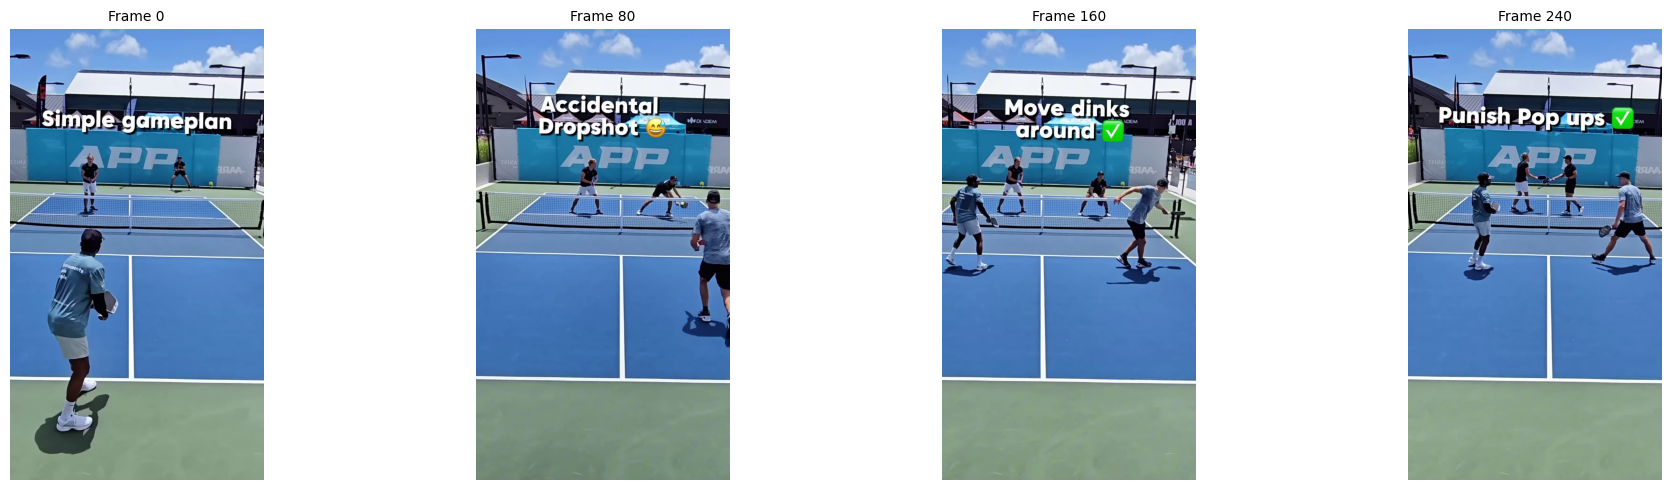

In [ ]:
# Create directories
os.makedirs('frames_original', exist_ok=True)
os.makedirs('frames_poses', exist_ok=True)
os.makedirs('frames_animated', exist_ok=True)

print(f"Extracting every {FRAME_SKIP}rd frame...\n")

cap = cv2.VideoCapture('video.mp4')
frame_count = 0
saved_count = 0
frame_indices = []

while True:
    success, frame = cap.read()
    if not success:
        break

    if frame_count % FRAME_SKIP == 0:
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        pil_image.save(f'frames_original/frame_{saved_count:04d}.png')
        frame_indices.append(frame_count)
        saved_count += 1

    frame_count += 1

cap.release()

print(f"✅ Extracted {saved_count} frames")
print(f"   Saved to frames_original/")

# Display sample frames
sample_indices = [0, saved_count//3, 2*saved_count//3, saved_count-1]
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, idx in enumerate(sample_indices):
    img = Image.open(f'frames_original/frame_{idx:04d}.png')
    axes[i].imshow(img)
    axes[i].set_title(f'Frame {idx}', fontsize=10)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Step 3: Extract Pose Skeletons with OpenPose

We'll use Replicate's OpenPose model to extract pose skeletons from each frame.

In [ ]:
# First install the library
!pip install -q controlnet_aux

# Then use it locally
from controlnet_aux import OpenposeDetector
from PIL import Image

print("🦴 Extracting pose skeletons from all frames...\n")
print("Using local OpenPose detector\n")

# Initialize detector (downloads model first time)
detector = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

pose_count = 0
skipped_count = 0

for i in tqdm(range(saved_count), desc="Extracting poses"):
    pose_path = f'frames_poses/pose_{i:04d}.png'

    # Skip if already extracted
    if os.path.exists(pose_path):
        skipped_count += 1
        continue

    try:
        # Load frame
        frame = Image.open(f'frames_original/frame_{i:04d}.png')

        # Extract pose
        pose_image = detector(frame)

        # Save pose
        pose_image.save(pose_path)
        pose_count += 1

    except Exception as e:
        print(f"\n❌ Error on frame {i}: {e}")
        # Save a blank pose as fallback
        blank = Image.new('RGB', (512, 512), color='black')
        blank.save(pose_path)
        continue

print(f"\n✅ Pose extraction complete!")
print(f"   Extracted: {pose_count} poses")
print(f"   Skipped (already done): {skipped_count} poses")

🦴 Extracting pose skeletons from all frames...

Using local OpenPose detector



annotator/ckpts/body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

annotator/ckpts/hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]


Extracting poses: 100%|██████████| 241/241 [06:32<00:00,  1.63s/it]


✅ Pose extraction complete!
   Extracted: 141 poses
   Skipped (already done): 100 poses


## Step 3.5: Preview Pose Skeletons

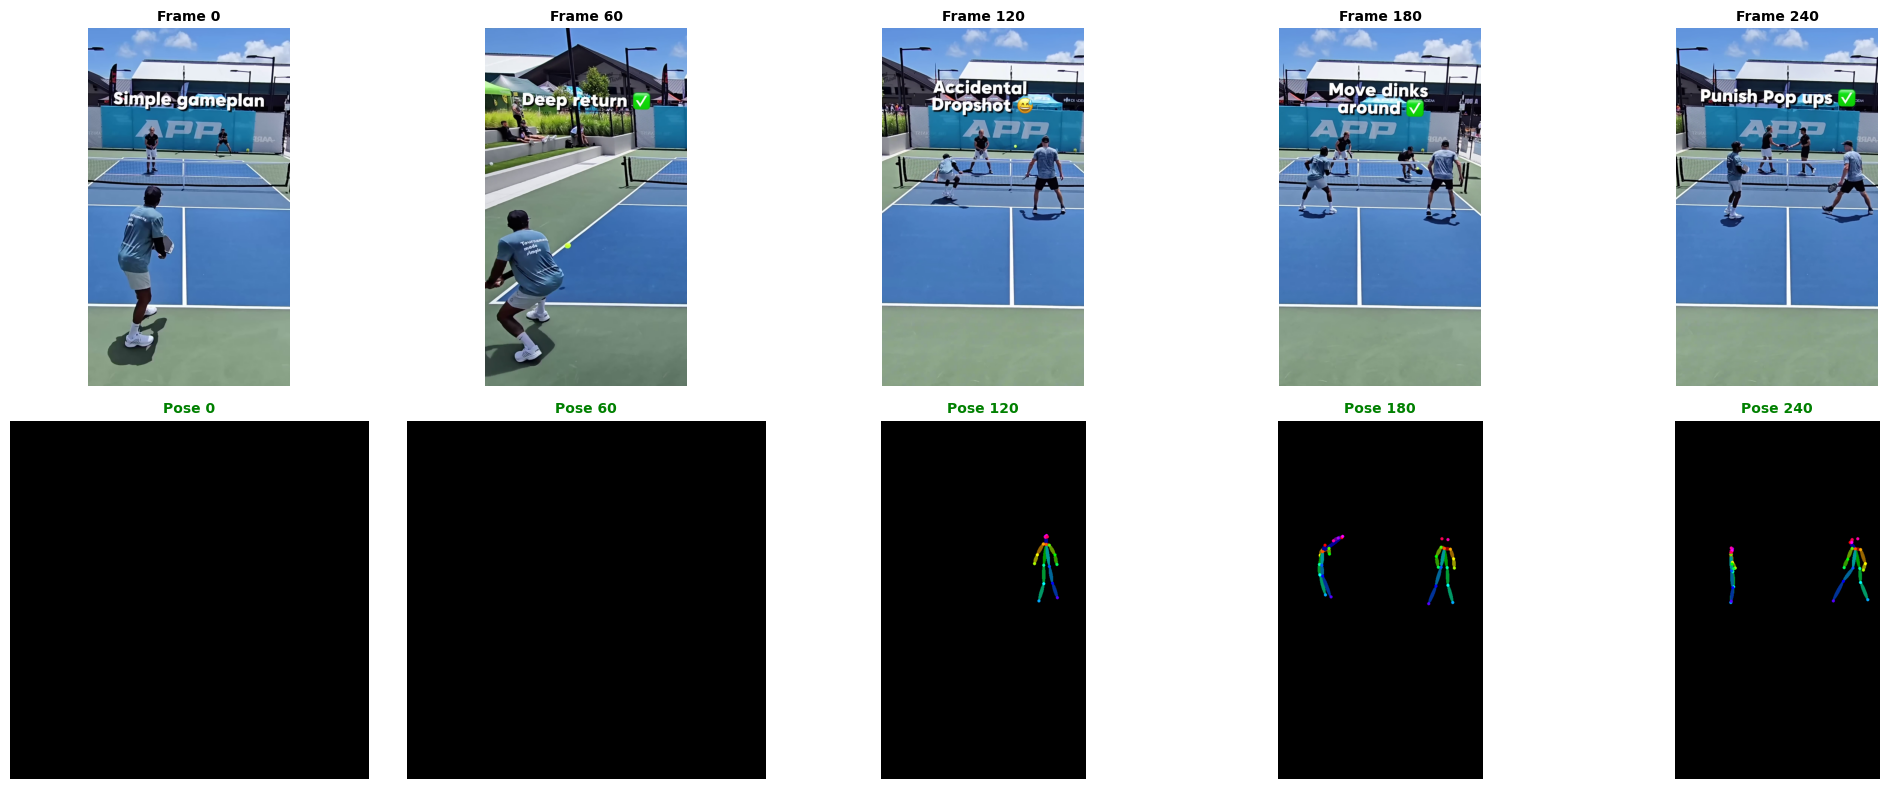


💡 The pose skeletons show the body structure that ControlNet will follow


In [ ]:
# Display original frames vs pose skeletons
sample_indices = [0, saved_count//4, saved_count//2, 3*saved_count//4, saved_count-1]

fig, axes = plt.subplots(2, len(sample_indices), figsize=(4*len(sample_indices), 8))

for i, idx in enumerate(sample_indices):
    # Original
    orig = Image.open(f'frames_original/frame_{idx:04d}.png')
    axes[0, i].imshow(orig)
    axes[0, i].set_title(f'Frame {idx}', fontsize=10, fontweight='bold')
    axes[0, i].axis('off')

    # Pose skeleton
    if os.path.exists(f'frames_poses/pose_{idx:04d}.png'):
        pose = Image.open(f'frames_poses/pose_{idx:04d}.png')
        axes[1, i].imshow(pose)
        axes[1, i].set_title(f'Pose {idx}', fontsize=10, fontweight='bold', color='green')
    else:
        axes[1, i].text(0.5, 0.5, 'No pose', ha='center', va='center')
        axes[1, i].set_title(f'Pose {idx}', fontsize=10, fontweight='bold', color='red')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 The pose skeletons show the body structure that ControlNet will follow")

## Step 4: Generate Animated Frames with ControlNet

Use ControlNet to generate animated frames that match the pose skeletons.

**This is the expensive step!** Each frame costs ~$0.002-0.005.

In [ ]:
import base64

print(f"\n🎨 Generating {saved_count} animated frames with ControlNet...\n")
print(f"💰 Estimated cost: ${saved_count * 0.011:.2f}")
print(f"⏱️  Estimated time: ~{saved_count * 12 / 60:.0f} minutes\n")

generated_count = 0
skipped_count = 0

for i in tqdm(range(saved_count), desc="Generating frames"):
    output_path = f'frames_animated/frame_{i:04d}.png'

    # Skip if already generated
    if os.path.exists(output_path):
        skipped_count += 1
        continue

    try:
        # Read pose image and convert to data URI
        with open(f'frames_poses/pose_{i:04d}.png', 'rb') as f:
            image_data = base64.b64encode(f.read()).decode('utf-8')
            data_uri = f"data:image/png;base64,{image_data}"

        # Use SDXL Lightning Multi-ControlNet with OpenPose
        output = replicate.run(
            "lucataco/sdxl-lightning-multi-controlnet",
            input={
                "control_image": data_uri,
                "controlnet_1": "openpose",
                "prompt": STYLE_PROMPT,
                "negative_prompt": NEGATIVE_PROMPT,
                "num_inference_steps": 8,
                "guidance_scale": 1.5,
                "controlnet_1_conditioning_scale": 0.7
            }
        )

        # Download generated image
        if output:
            if isinstance(output, list):
                output = output[0]
            response = requests.get(str(output))
            animated_image = Image.open(BytesIO(response.content))
            animated_image.save(output_path)
            generated_count += 1

    except Exception as e:
        print(f"\n❌ Error on frame {i}: {e}")
        print(f"Saving progress and continuing...")
        continue

print(f"\n✅ Generation complete!")
print(f"   Generated: {generated_count} frames")
print(f"   Skipped (already done): {skipped_count} frames")


🎨 Generating 241 animated frames with ControlNet...

💰 Estimated cost: $2.65
⏱️  Estimated time: ~48 minutes




Generating frames:   1%|          | 3/241 [00:00<00:28,  8.44it/s]


❌ Error on frame 0: ReplicateError Details:
status: 404
detail: The requested resource could not be found.
Saving progress and continuing...

❌ Error on frame 1: ReplicateError Details:
status: 404
detail: The requested resource could not be found.
Saving progress and continuing...

❌ Error on frame 2: ReplicateError Details:
status: 404
detail: The requested resource could not be found.
Saving progress and continuing...



Generating frames:   2%|▏         | 5/241 [00:00<00:29,  8.04it/s]


❌ Error on frame 3: ReplicateError Details:
status: 404
detail: The requested resource could not be found.
Saving progress and continuing...

❌ Error on frame 4: ReplicateError Details:
status: 404
detail: The requested resource could not be found.
Saving progress and continuing...



Generating frames:   3%|▎         | 8/241 [00:00<00:25,  9.11it/s]


❌ Error on frame 5: ReplicateError Details:
status: 404
detail: The requested resource could not be found.
Saving progress and continuing...

❌ Error on frame 6: ReplicateError Details:
status: 404
detail: The requested resource could not be found.
Saving progress and continuing...

❌ Error on frame 7: ReplicateError Details:
status: 404
detail: The requested resource could not be found.
Saving progress and continuing...



Generating frames:   5%|▍         | 11/241 [00:01<00:23,  9.72it/s]


❌ Error on frame 8: ReplicateError Details:
status: 404
detail: The requested resource could not be found.
Saving progress and continuing...

❌ Error on frame 9: ReplicateError Details:
status: 404
detail: The requested resource could not be found.
Saving progress and continuing...

❌ Error on frame 10: ReplicateError Details:
status: 404
detail: The requested resource could not be found.
Saving progress and continuing...


Generating frames:   5%|▍         | 11/241 [00:01<00:27,  8.42it/s]


KeyboardInterrupt: 

## Step 5: Preview Generated Frames

In [ ]:
# Display comparison: Original → Pose → Animated
sample_indices = [0, saved_count//4, saved_count//2, 3*saved_count//4, saved_count-1]

fig, axes = plt.subplots(3, len(sample_indices), figsize=(4*len(sample_indices), 12))

for i, idx in enumerate(sample_indices):
    # Original
    orig = Image.open(f'frames_original/frame_{idx:04d}.png')
    axes[0, i].imshow(orig)
    axes[0, i].set_title(f'Original {idx}', fontsize=10, fontweight='bold')
    axes[0, i].axis('off')

    # Pose
    pose = Image.open(f'frames_poses/pose_{idx:04d}.png')
    axes[1, i].imshow(pose)
    axes[1, i].set_title(f'Pose {idx}', fontsize=10, fontweight='bold')
    axes[1, i].axis('off')

    # Animated
    if os.path.exists(f'frames_animated/frame_{idx:04d}.png'):
        anim = Image.open(f'frames_animated/frame_{idx:04d}.png')
        axes[2, i].imshow(anim)
        axes[2, i].set_title(f'Animated {idx}', fontsize=10, fontweight='bold', color='green')
    else:
        axes[2, i].text(0.5, 0.5, 'Not generated', ha='center', va='center')
        axes[2, i].set_title(f'Animated {idx}', fontsize=10, fontweight='bold', color='red')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Check if:")
print("  ✓ Poses are preserved (animated matches pose skeleton)")
print("  ✓ Style is consistent across frames")
print("  ✓ Characters look similar frame-to-frame")

## Step 6: Stitch Frames into Video

In [ ]:
print("Stitching frames into video...\n")

output_filename = "iteration5_output.mp4"

# Use ffmpeg to create video from image sequence
cmd = [
    'ffmpeg',
    '-framerate', str(output_fps),
    '-i', 'frames_animated/frame_%04d.png',
    '-c:v', 'libx264',
    '-pix_fmt', 'yuv420p',
    '-preset', 'slow',
    '-crf', '18',
    output_filename,
    '-y'
]

result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print(f"✅ Video created: {output_filename}")
    print(f"   Output FPS: {output_fps:.2f}")
    print(f"   Duration: ~{duration:.2f}s")
else:
    print(f"❌ ffmpeg error: {result.stderr}")